In [1]:
## imports
import sys
import os
import numpy as np
import xarray as xr
import cmocean
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import gridspec
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import eofs
from eofs.xarray import Eof
import cftime
import nc_time_axis
import cmocean as cmo
import mtspec

# from pylab import *

import datetime
import time
import glob, os
import math
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import xskillscore
from defs import trim_axs, amocstrength, corsst, pvalmask, lon180, amocstrength_100yr
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
import cartopy.mpl.ticker as cticker
import matplotlib.ticker as mticker

In [2]:
folder = ''

In [3]:
#These masks are have been saved from Fig05Fig08.ipynb
atlmask = xr.open_dataset('/Users/6497241/surfdrive/Documents/PlioMIP2-OHT/Data/Processed/1x1Atlmask.nc') #atlmask.region.plot()
oceanmaskE280 = xr.open_dataset('/Users/6497241/surfdrive/Documents/PlioMIP2-OHT/Data/Processed/1x1oceanmaskE280.nc')
oceanmaskEoi400 = xr.open_dataset('/Users/6497241/surfdrive/Documents/PlioMIP2-OHT/Data/Processed/1x1oceanmaskEoi400.nc')

In [4]:
modellist =  ['GISS2.1G', 'EC-Earth3-LR', 'CCSM4-UoT', 'CCSM4-Utr','CCSM4', 'CESM1.2', 'CESM2', 'IPSL-CM5A', 'IPSL-CM5A2','IPSL-CM6A','MIROC4m','COSMOS', 'HadCM3', 'NorESM1-F','HadGEM3']

def preprocessing(ds): 
    ds = lon180(ds)
    return ds.expand_dims(dim='model')

paths = []
for i in range(len(modellist)):
    paths.append(folder+modellist[i]+'/E280/'+'UVa_100yr.nc')
    
dsE280 = xr.open_mfdataset(paths, concat_dim='model',combine='nested', preprocess = preprocessing)
uaE280 = dsE280.ua.where(dsE280.ua>-1e10).where(dsE280.ua<1e10).where(dsE280.ua.count(dim='model')>10)[:-1] #Only show U where more than 10 models indicate ocean grid cells
mmmE280 = uaE280.mean(dim='model').where(oceanmaskE280.sss>0)

paths = []
for i in range(len(modellist)):
    paths.append(folder+modellist[i]+'/Eoi400/'+'UVa_100yr.nc')
    
dsEoi400 = xr.open_mfdataset(paths, concat_dim='model',combine='nested', preprocess = preprocessing)
uaEoi400 = dsEoi400.ua.where(dsEoi400.ua>-1e10).where(dsEoi400.ua<1e10).where(dsEoi400.ua.count(dim='model')>10)[:-1] #Only show SSS where more than 10 models indicate ocean grid cells
mmmEoi400 = uaEoi400.mean(dim='model').where(oceanmaskEoi400.sss>0)

In [5]:
#Function to compute the wind curl dv/dx-du/dy
def windcurl(u,v):
    du = u[1:,1:].values-u[:-1,1:].values
    dv = v[1:,1:].values-v[1:,:-1].values
    
    du = xr.DataArray(data = du, dims = ["lat","lon"], coords = dict(lat = u.lat[1:], lon=u.lon[1:]))
    dv = xr.DataArray(data = dv, dims = ["lat","lon"], coords = dict(lat = v.lat[1:], lon=v.lon[1:]))
    
    dlat = du.copy(deep=True).fillna(0)*0+1
    dlon = dv.copy(deep=True).fillna(0)*0+1
    
    #2-D array with spacing of horizontal T grid
    r = 6.37122e6 #radius Earth in m
    a = np.deg2rad((du.lon[2]-du.lon[1]))*r*np.cos(np.deg2rad(du.lat)) #Lon spacing. Units: m

    for i in range(len(du.lon)):
        dlon[:,i]=a.values

    a = np.deg2rad((dv.lat[2]-dv.lat[1]))*r
    for i in range(len(dv.lat)):
        dlat[i,:]=a.values

    curl = (dv/dlon-du/dlat)*10**5
    return(curl)

In [6]:
dscurlE = xr.Dataset(data_vars = dict(curl=(["model", "lat","lon"], np.zeros([len(modellist),len(dsE280.lat)-1, len(dsE280.lon)-1]))), coords = dict(model = modellist, lat = dsE280.lat[1:].values, lon = dsE280.lon[1:].values))
dscurlEoi = xr.Dataset(data_vars = dict(curl=(["model", "lat","lon"], np.zeros([len(modellist),len(dsE280.lat)-1, len(dsE280.lon)-1]))), coords = dict(model = modellist, lat = dsE280.lat[1:].values, lon = dsE280.lon[1:].values))

for i in range(len(modellist)):
    dscurlE.curl[i] = windcurl(dsE280.ua[i], dsE280.va[i]).where(oceanmaskE280.sss>0)
    dscurlEoi.curl[i] = windcurl(dsEoi400.ua[i], dsEoi400.va[i]).where(oceanmaskEoi400.sss>0)            

In [7]:
E280curl = dscurlE.curl.where(atlmask.region>-1).where(oceanmaskE280.sss>0).mean(dim='lon').mean(dim='model')
Eoi400curl = dscurlEoi.curl.where(atlmask.region>-1).where(oceanmaskEoi400.sss>0).mean(dim='lon').mean(dim='model')
std = (dscurlEoi.curl.where(atlmask.region>-1).where(oceanmaskEoi400.sss>0).mean(dim='lon')-dscurlE.curl.where(atlmask.region>-1).where(oceanmaskE280.sss>0).mean(dim='lon')).std(dim='model')

In [8]:
lat = dscurlE.lat
lon = dscurlE.lon

#Compare with OHT by gyres
dsE280 = xr.Dataset(data_vars = dict(oht=(["model", "lat"], np.zeros([len(modellist),len(lat)]))), coords = dict(model = modellist, lat = lat))
dsEoi400 = xr.Dataset(data_vars = dict(oht=(["model", "lat"], np.zeros([len(modellist),len(lat)]))), coords = dict(model = modellist, lat = lat))

for i in range(len(modellist)):
    model = modellist[i]
    ds1 = xr.open_dataset(folder+model+'/E280/decomOHT_100yr.nc')
    dsE280.oht[i,:]= ds1.OHTaz.interp(lat=lat, method='linear')
    
    ds2 = xr.open_dataset(folder+model+'/Eoi400/decomOHT_100yr.nc')
    dsEoi400.oht[i,:]= ds2.OHTaz.interp(lat=lat, method='linear')

HazE280 = dsE280.oht.where(lat>=20).where(lat<=40)
HazEoi400 = dsEoi400.oht.where(lat>=20).where(lat<=40)

difoht = (HazEoi400-HazE280).mean(dim='lat')

In [9]:
#Latitudinal weights for meridional averages
weights = np.cos(np.deg2rad(dsE280.lat))
weights.name = "weights"

#Compute the change in wind curl using the minimum wind curl in the subtropical gyre
difcurl = dscurlEoi.curl.where(lat>=20).where(lat<=40).mean(dim='lon').min(dim='lat')-dscurlE.curl.where(lat>=20).where(lat<=40).mean(dim='lon').min(dim='lat')

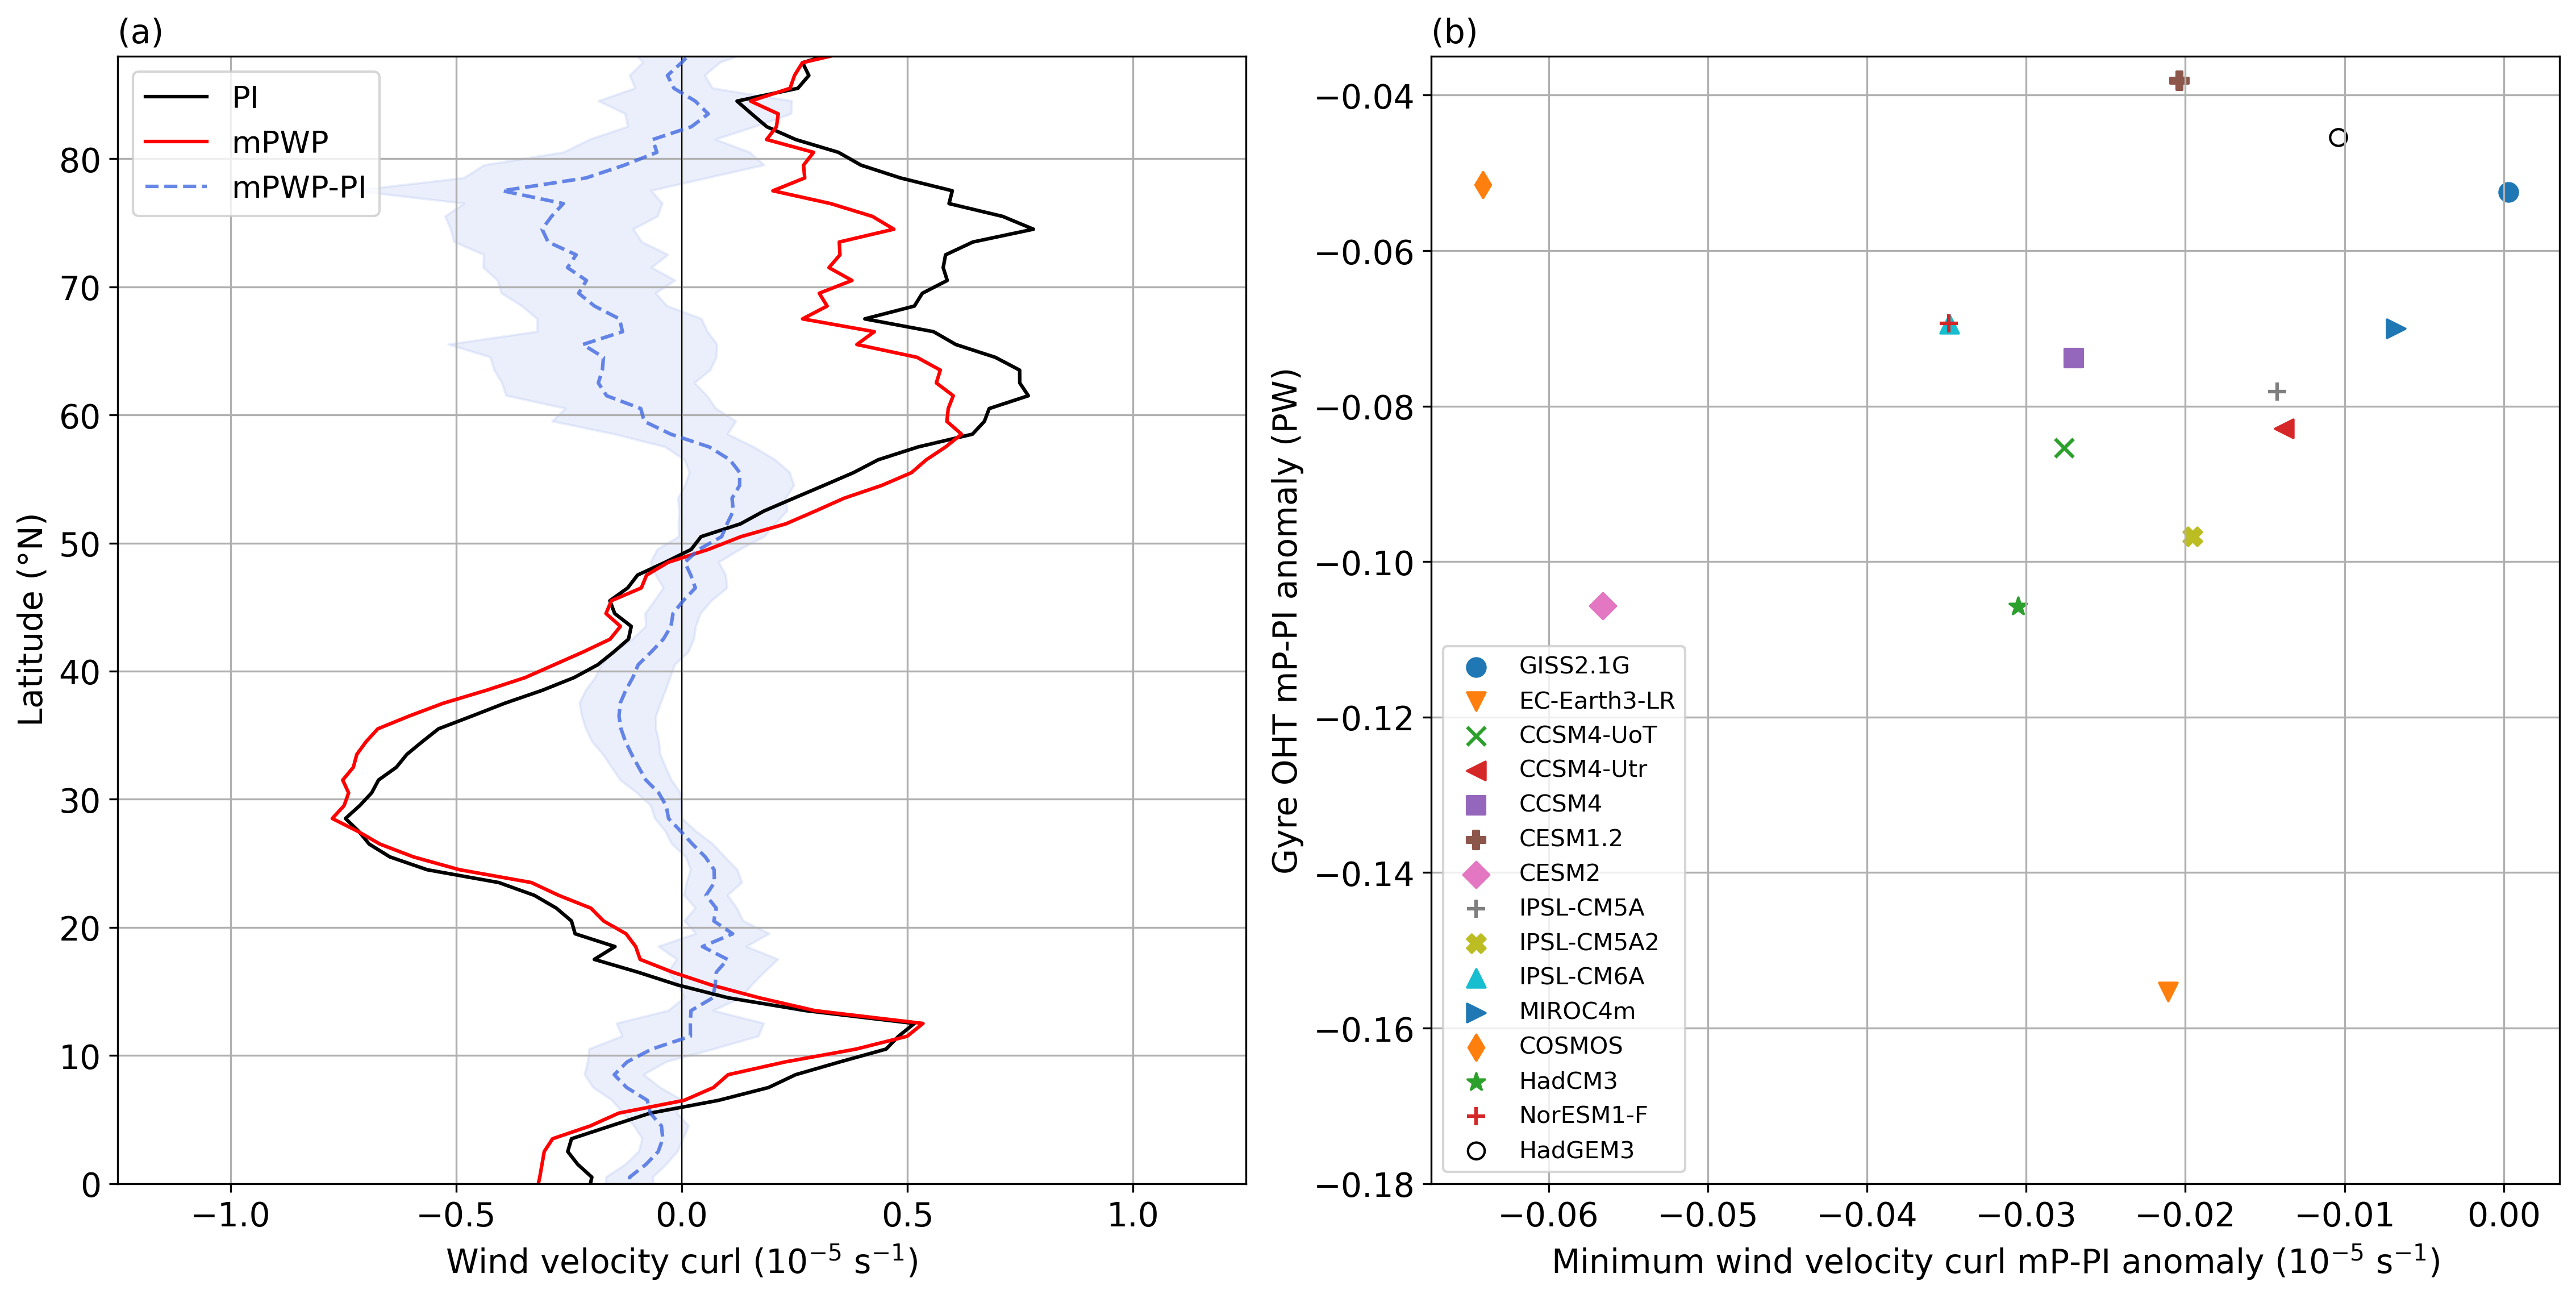

In [10]:
plt.rcParams['xtick.labelsize']=14
plt.rcParams['ytick.labelsize']=14
plt.rcParams['axes.labelsize'] = 14

fig1, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,7.5),dpi=300, constrained_layout=True)

divnorm = colors.TwoSlopeNorm(vmin=-10., vcenter=0, vmax=10)

ax[0].set_ylim([0,90])
ax[0].set_xlim([-1.25,1.25])
ax[0].set_ylabel('Latitude ($\degree$N)', fontsize=14)
ax[0].plot([0,0], [0,90], color='black', linewidth=0.5)
ax[0].plot((E280curl), E280curl.lat, label='PI', color='black')
ax[0].plot((Eoi400curl), E280curl.lat, label='mPWP', color='red')
ax[0].plot((Eoi400curl-E280curl), E280curl.lat, color='royalblue', alpha=0.8, linestyle='--', label='mPWP-PI')
ax[0].set_xlabel('Wind velocity curl (10$^{-5}$ s$^{-1}$)', fontsize=14)
ax[0].legend(loc='upper left', fontsize=13)
ax[0].set_title('(a)', loc='left', fontsize=14)
ax[0].grid()
ax[0].fill_betweenx(E280curl.lat, (Eoi400curl-E280curl)-std, (Eoi400curl-E280curl)+std, color='royalblue', alpha=0.1)
ax[0].set_ylim([0,88])

markers = ["o","v","x","<","s","P","D","+","X","^",">","d","*","+","o"]
for j in range(0,len(modellist)-1):
    scatter = ax[1].scatter(difcurl[j], difoht[j], s=60, c = 'C'+str(j), label=modellist[j], marker=markers[j])

scatter = ax[1].scatter(difcurl[-1], difoht[-1], s=50, facecolors='none', edgecolors = 'k', label=modellist[-1], marker=markers[-1])
ax[1].set_ylim([-0.18,-0.035])
ax[1].grid()
ax[1].set_title('(b)', loc='left', fontsize=14)
ax[1].set_xlabel('Minimum wind velocity curl mP-PI anomaly (10$^{-5}$ s$^{-1}$)', fontsize=14)
ax[1].set_ylabel('Gyre OHT mP-PI anomaly (PW)', fontsize=14)
ax[1].legend(loc='lower left', fontsize=10)

plt.savefig('fig11.png', bbox_inches='tight')

In [11]:
xr.Dataset.to_netcdf(dscurlE.where(oceanmaskE280.sss>0), path = '/Users/6497241/surfdrive/Documents/PlioMIP2-OHT/Data/Processed/UVcurlE280.nc')
xr.Dataset.to_netcdf(dscurlEoi.where(oceanmaskEoi400.sss>0), path = '/Users/6497241/surfdrive/Documents/PlioMIP2-OHT/Data/Processed/UVcurlEoi400.nc')

In [12]:
import scipy
print(scipy.stats.linregress(difcurl, difoht))

LinregressResult(slope=0.19279409255620375, intercept=-0.07376778890224173, rvalue=0.11397722379647028, pvalue=0.6858757743675001, stderr=0.4660844036722796)
